# Test sanssouci on synthetic data

In this introductory notebook, we test the *sanssouci* module on synthetic data. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

sanssouci_dir='../'
import sys
sys.path.append(sanssouci_dir)
import sanssouci as sa

import random


## 1. Generate phantom data

We observe $n=n_0 + n_1$ independent $p$-dimensional vectors $X^{(j)} \sim \mathcal{N}(\mu^{(0)},\Sigma)$ for $1\leq j \leq n_0$, and  $X^{(j)} \sim \mathcal{N}(\mu^{(1)},\Sigma)$ for $1\leq j \leq n_1$. Our aims it to test the null hypotheses: $\mathcal{H}_{0,i}: \theta^{(0)}_i=\theta^{(1)}_i$, simultaneously for $1\leq i \leq p$. 

We denote by $p_0$ the number of true null hypotheses and by $\pi_0 = p_0/p$ the fraction of true nulls (proportion of noise in the data). 

We assume that:

- $\Sigma = \rho^2 + (1-\rho^2) I_p$, meaning that the correlation between any two variables is $\rho$; the case $\rho=0$ corresponds to independent tests. 

- for $i = 1, \cdots, p_0$, $\mu^{(0)} = \mu^{(1)} = 0$
- for $i = p_0+1, \cdots, p$, $\mu^{(0)} = 0$ and $\mu^{(1)} = s$, where $s$ controls the signal to noise ratio of the problem.

For each dimension, the null hypothesis: $\mathcal{H}_{0,i}: \theta^{(0)}_i=\theta^{(1)}_i$ is tested by a two-sample Welch test. 

The simulation parameters are set as follows.

In [2]:
random.seed(a=2021)

p = 50000         # number of variables     (eg : number of voxels in an image)
n = 80            # number of observations  (eg : number of images)
pi0 = 0.99        # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0*p)) # number of true null hypotheses (non active voxels)
rho = 0.3         # equi-correlation
s = 1             # signal to noise ratio

# generate noise
Z=np.random.randn(n,p)
w=np.random.randn(n)
W=Z.copy()
for i in range(p):
  W[:,i]=w[:]
Y=np.sqrt(1-rho)*Z + np.sqrt(rho)*W

# add signal (for false null hypotheses)
categ=np.random.binomial(1, 0.5, size=n) # two balanced categories
X = Y.copy()
w1=np.where(categ==1)
X[w1, (p0+1):p] = Y[w1, (p0+1):p] + s


We perform Welch $t$-tests on each variable to compare whether the mean values are significantly different. The histogram of the $p=50000$ p-values is shown. 

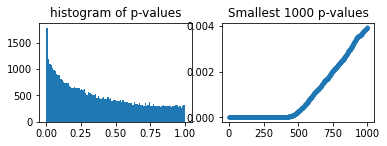

In [3]:
# calculate and display the p-values
rwt=sa.row_welch_tests(X, categ)
pval = rwt['p_value']

plt.subplot(2, 2, 1)
plt.hist(pval, 100)  #100 bins are used for the histogram
plt.title('histogram of p-values')

s_pval = np.sort(pval)
plt.subplot(2, 2, 2)
plt.plot(s_pval[:1000], '.')
plt.title('Smallest 1000 p-values')

plt.show()



## 2. Classical multiple testing: FDR control

A standard way to account for the fact that we are performing many tests simultaneously is to control the False Discovery Rate (FDR), that is, the expected proportion of false positives among the selected hypotheses. This is classically done using the Benjamini-Hochberg (1995) procedure.

The Benjamini-Hochberg procedure at level $\alpha$ rejects the smallest $I$ $p$-values, where $I$ is the largest crossing point between the sorted $p$-values and the line passing by $(0,0)$ and $(p, \alpha)$:

p_i: 0.0013047473623357675
i: 654
FP: 160
FDP: 0.24464831804281345


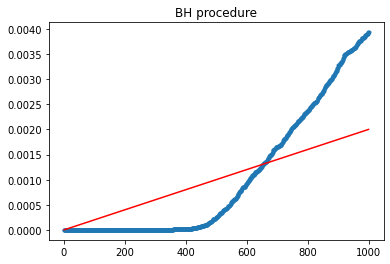

In [4]:
# adapted from https://matthew-brett.github.io/teaching/fdr.html
alpha = 0.1
s_pval = np.sort(pval)
i = np.arange(1, p+1) # the 1-based i index of the p values, as in p(i)

plt.plot(i[:1000], s_pval[:1000], '.')
plt.plot(i[:1000], alpha * i[:1000] / p, 'r')
plt.title("BH procedure")

below = s_pval < (alpha * i / p)   # True where p(i)<qi/N
I = np.max(np.where(below)[0]) + 1 # Max Python array index where p(i)<qi/N
print('p_i:', s_pval[I-1])
print('i:', I) # Python indices 0-based, we want 1-based

i0 = np.arange(1, p0+1)
below0 = pval[:p0] < (alpha * (I-1) / p)
FP = np.sum(below0)
print('FP:', FP)

FDP = FP/I
print('FDP:', FDP)

Here, the BH procedure ensures that the FDR, that is, the expected proportion of false positives (FDP) among the 427 selected genes is less than 0.1. In this particular simulation, the true FDP is approximately 0.0328.

## 3. Post hoc inference


Post hoc inference makes it possible to *build confidence statements on the number of true/false positives within any set $S$ of genes*: $S$ may be selected after seing the data (e.g., $S$ may be the set of rejections by the BH procedure), and multiple choices of $S$ are allowed. Post hoc inference has been popularized by Goeman and Solari (2011) and its application to neuroimaging data is illustrated in Rosenblatt *et al*, 2018.  This approach is implemented in the R package 'ARI', which relies on the R package 'cherry'.

Below, we use an equivalent formulation of the bound of Goeman and Solari (2011) implemented in the python package 'sansSouci.python'. 

### Upper bound on $p_0$

We obtain an upper bound on $p_0$, the number of true null hypotheses, by taking $S=$ all $p$ hypotheses. With probability $1-\alpha = 0.9$ the number of true null hypotheses should be less than this bound:

In [5]:
alpha = 0.1
thr=sa.t_linear(alpha, np.arange(1,p+1), p)

bound = sa.max_fp(pval, thr)
print("\nbound:",bound)
print('\nNumber of true null hypotheses:', p0)


bound: 49580.0

Number of true null hypotheses: 49500


### Number of false positives by BH

Then, we obtain an upper bound on the number of false positives among the hypotheses rejected by the BH procedure

In [6]:
bound = sa.max_fp(s_pval[np.where(below)], thr)
print("\nbound:",bound)
print('\nNumber of false positives:', FP)


bound: 234.0

Number of false positives: 160


In this particular example, the bound is valid, but not very tight as 2 << 155.

### Confidence envelopes for the FDP

Another typical output of post hoc inference is confidence envelopes for the False Discovery Proportion:

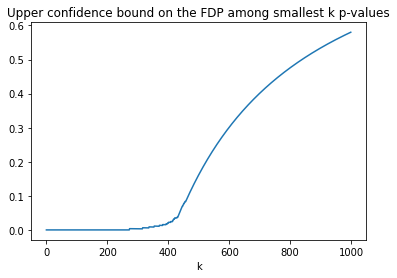

In [7]:
maxFP = sa.curve_max_fp(s_pval, thr)
maxFDP = maxFP/i

plt.plot(maxFDP[:1000], )
plt.title("Upper confidence bound on the FDP among smallest k p-values")
plt.xlabel("k")
plt.show()

## 4. Improved post hoc inference by adaptation to the dependence

As discussed in Blanchard, Neuvial, and Roquain (2020), the above-described bound is known to be valid only under certain positive dependence assumptions (PRDS) on the joint $p$-value distribution. Although the PRDS assumption is widely accepted for fMRI studies (see Genovese, Lazar, and Nichols (2002), Nichols and Hayasaka (2003)), we argue (and demonstrate below) that this assumption yields overly conservative post hoc bounds. Indeed, the Simes bound is by construction not adaptive to the specific type of dependence at hand for a particular data set.

To bypass these limitations, Blanchard, Neuvial, and Roquain (2020) have proposed a randomization-based procedure known as $\lambda$-calibration, which yields tighter bounds that are adapted to the dependency observed in the data set at hand. We note that a related approach has been proposed by Hemerik, Solari, and Goeman (2019), and Andreella *et al* (2020).  In the case of two-sample tests, this calibration can be achieved by permutation of class labels, which is available in the sansSouci.python package:

In [8]:
B = 1000
pval0 = sa.get_perm_p(X, categ, B=B , row_test_fun=sa.row_welch_tests)
piv_stat = sa.get_pivotal_stats(pval0, K=p)
lam = np.quantile(piv_stat, alpha)

print('\nalpha:', alpha)
print('\nlambda:', np.round(lam, 2))


alpha: 0.1

lambda: 0.23


Here we obtain $\lambda > \alpha$. The gap between $\lambda$ and $\alpha$ can be interpreted as the power gain obtained by $\lambda$-calibration.  Below we show how this translates into tighter post hoc bounds.

### Upper bound on 𝑝0, the number of true null hypotheses

We obtain an upper bound on $p_0$, the number of true null hypotheses, by taking $S=$ all $p$ hypotheses. With probability $1-\alpha = 0.9$ the number of true null hypotheses should be less than this bound:

In [9]:
thr_cal=sa.t_linear(lam, np.arange(1,p+1), p)

bound = sa.max_fp(pval, thr_cal)
print("\nbound:",bound)
print('\nNumber of true null hypotheses:', p0)


bound: 49550.0

Number of true null hypotheses: 49500


As expected, the bound is still valid, and tighter than before.

### Number of false positives by BH

Upper bound on the number of false positives among the hypotheses rejected by the BH procedure

In [10]:
bound = sa.max_fp(s_pval[np.where(below)], thr_cal)
print("\nbound:",bound)
print('\nNumber of false positives:', FP)


bound: 204.0

Number of false positives: 160


Again, the bound is still valid, and tighter than before.

### Confidence envelopes for the FDP



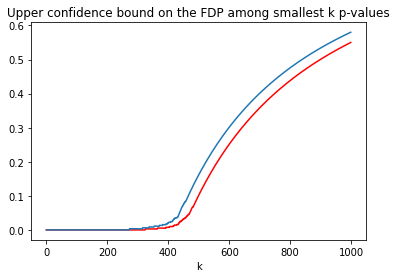

In [11]:
maxFP_cal = sa.curve_max_fp(s_pval, thr_cal)
maxFDP_cal = maxFP_cal/i

plt.plot(maxFDP_cal[:1000], '-r', label = 'Simes')
plt.plot(maxFDP[:1000], '-', label = 'Simes + lambda-calibration')
plt.title('Upper confidence bound on the FDP among smallest k p-values')
plt.xlabel('k')
plt.show()

The upper bound obtained by $\lambda$-calibration (in red) is uniformly tighter than the original "parametric" one.